## Loading the Data and the Libraries

In [9]:
import numpy as np
import pandas as pd
import scanpy as ad
import anndata as an
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.dpi": 300, "savefig.dpi": 300}) # I like high-res figures 
from umap import UMAP

In [2]:
E_base          = np.load("/Users/ali/Downloads/emb_base_5k (1).npy")
E_c9_als_up     = np.load("/Users/ali/Downloads/emb_C9orf72_ALS_up_5k.npy")
E_k5_als_down   = np.load("KIF5A_perturb_ALS_down.npy")
E_multiple_down = np.load("multiple_perturb_ALS_down.npy")

base               = ad.read_h5ad("adata_base_5k.h5ad")
C9orf72_als_up     = ad.read_h5ad("adata_C9orf72_ALS_up_5k.h5ad")
KIF5A_als_down     = ad.read_h5ad("adata_KIF5A_perturb_ALS_down.h5ad")
multiple_als_down  = ad.read_h5ad("adata_multiple_perturb_ALS_down.h5ad")

## 4.1. Helper Functions

Pretty much the same functions as used in the previous notebooks, with names slightly changed. But here's a summary:
- `_centroid`: Calculates the centroids of the embeddings.
- `_norm_labels`: Normalizes labels to handle plots and subsetting. 
- `_euclid`: Finds the Euclidean distance between two points. 
- `_cosine`: Calculates the Cosine similarity between two vectors.

In [ ]:
def _centroid(X):
    X = np.asarray(X)
    if X.ndim != 2 or X.shape[0] == 0:
        raise ValueError("Empty slice passed to _centroid")
    return X.mean(axis=0)

def _norm_labels(series):
    return series.astype(str).str.strip().str.upper()

def _euclid(a, b):
    return float(np.linalg.norm(a - b))

def _cosine(u, v):
    a = np.linalg.norm(u)
    b = np.linalg.norm(v)
    if a == 0 or b == 0:
        return np.nan
    return float(np.dot(u, v) / (a * b))

## 4.2. Centroids Analysis

### 4.2.1. PCA Plots

To find drug targets, I want to determine which perturbation had the most effect on shifting our disease (`ALS`) states towards a healthier (`PN`) state. Therefore, I calculated the centroids of each state (base and the three perturbations), and reduced their dimensions using PCA to visualize them in the latent space. 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


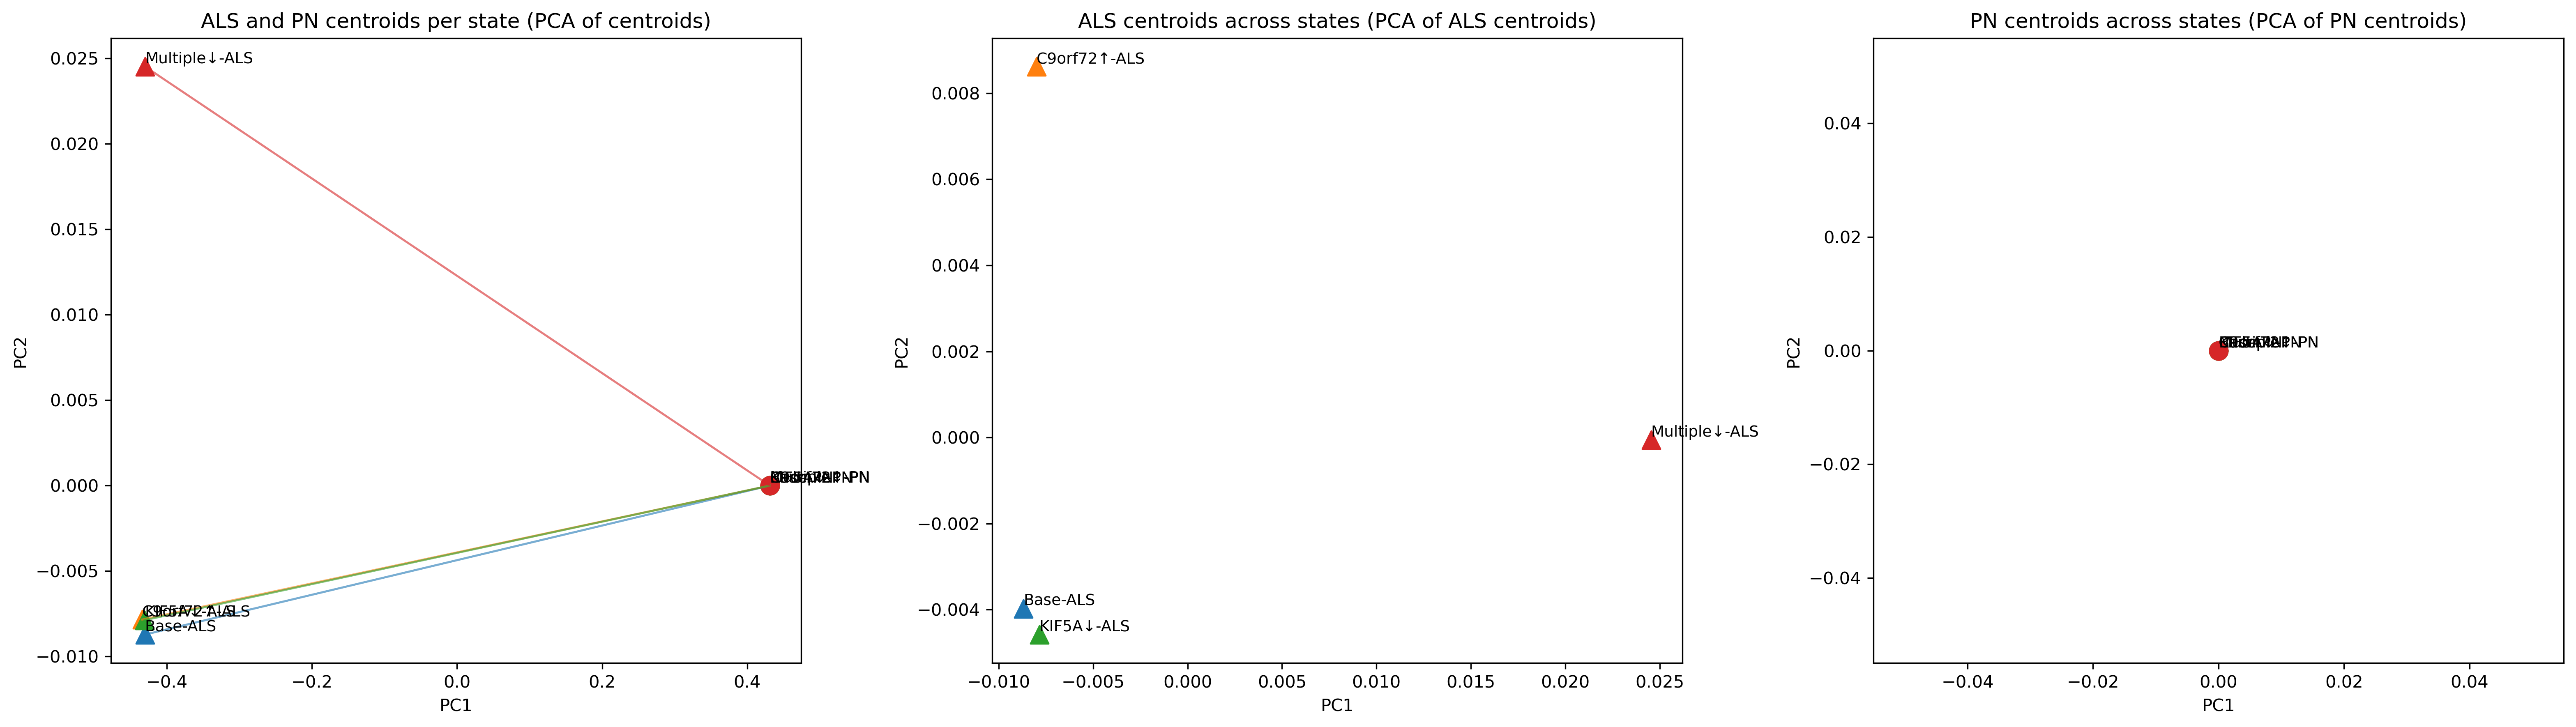

In [12]:
names  = ["Base","C9orf72↑","KIF5A↓","Multiple↓"]
embeds = [E_base, E_c9_als_up, E_k5_als_down, E_multiple_down]
adatas = [base,   C9orf72_als_up, KIF5A_als_down, multiple_als_down]

centroids = []
states    = []
cohorts   = []

for n, E, A in zip(names, embeds, adatas):
    if "Condition" not in A.obs.columns:
        raise KeyError(f"Missing 'Condition' in {n}")
    cond = _norm_labels(A.obs["Condition"])
    for c in ["ALS", "PN"]:
        idx = np.flatnonzero(cond.values == c)
        if idx.size > 0:
            if E.shape[0] < idx.max() + 1:
                raise ValueError(f"Embeddings for {n} have {E.shape[0]} rows but adata has index up to {idx.max()}.")
            centroids.append(_centroid(E[idx]))
            states.append(n)
            cohorts.append(c)

if len(centroids) == 0:
    raise ValueError("No ALS/PN matches found after normalization. Inspect 'Condition' values.")

X = np.vstack(centroids)

state_list    = list(dict.fromkeys(states))
state_colors  = {s: plt.cm.tab10(i % 10) for i, s in enumerate(state_list)}
cohort_marker = {"ALS": "^", "PN": "o"}

def _scatter_to_ax(ax, X2, labs_state, labs_cohort, title):
    for i, (s, c) in enumerate(zip(labs_state, labs_cohort)):
        ax.scatter(X2[i,0], X2[i,1], s=110, c=[state_colors[s]], marker=cohort_marker.get(c, "o"))
        ax.text(X2[i,0], X2[i,1], f"{s}-{c}", fontsize=9, ha="left", va="bottom")
    for s in state_list:
        idx = [i for i, ss in enumerate(labs_state) if ss == s]
        if len(idx) >= 2:
            ax.plot(X2[idx,0], X2[idx,1], linewidth=1.2, alpha=0.6, c=state_colors[s])
    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

fig, axes = plt.subplots(1, 3, figsize=(21, 6), dpi=300)

if X.shape[0] >= 2:
    pca_all = PCA(n_components=2, random_state=0).fit(X)
    Xp_all  = pca_all.transform(X)
    _scatter_to_ax(axes[0], Xp_all, states, cohorts, "ALS and PN centroids per state (PCA of centroids)")
else:
    axes[0].axis("off")

idx_als = [i for i, c in enumerate(cohorts) if c == "ALS"]
if len(idx_als) >= 2:
    X_als = X[idx_als]
    pca_als = PCA(n_components=2, random_state=0).fit(X_als)
    Xp_als  = pca_als.transform(X_als)
    _scatter_to_ax(axes[1], Xp_als, [states[i] for i in idx_als], ["ALS"]*len(idx_als), "ALS centroids across states (PCA of ALS centroids)")
else:
    axes[1].axis("off")

idx_pn = [i for i, c in enumerate(cohorts) if c == "PN"]
if len(idx_pn) >= 2:
    X_pn = X[idx_pn]
    pca_pn = PCA(n_components=2, random_state=0).fit(X_pn)
    Xp_pn  = pca_pn.transform(X_pn)
    _scatter_to_ax(axes[2], Xp_pn, [states[i] for i in idx_pn], ["PN"]*len(idx_pn), "PN centroids across states (PCA of PN centroids)")
else:
    axes[2].axis("off")

plt.tight_layout()
plt.show()

**Figure 1**: In this figure, we can see that the centroids of `ALS` in _KIF5A_ seems to be the closest to the base ALS cells, which suggests that perhaps its effect wasn't as great as the remaining perturbations. However, when we plot them with the `PN` centroids, we can see that there's quite some distance between `PN` cells' centroids, and the perturbed `ALS` cells. 

### 4.1.2. Distance in Euclidean Space 

To meaasure if the centroids have moved closer or further from each other, I am calculating the Euclidean distance of the centroids (`PN` vs `ALS`) in the perturbations and comparing that distance to the base's centroids. And based on our analysis, it seems like only in multiple perturbations does that distance reduce slightly. I also calculated the alignment vector to determine if the direction reverses for any of the perturbation, but since that's also very close to 1, it suggests that it doesn't differ too much. The alignment vector is simply the cosine similarity score between the perturbed `ALS` vs `PN` compared to the reference `ALS` vs `PN`, and a score <0 would have suggested that the direction reverses for the `ALS` cells which would have been promising. 

In [ ]:
names  = ["Base","C9orf72↑","KIF5A↓","Multiple↓"]
embeds = [E_base, E_c9_als_up, E_k5_als_down, E_multiple_down]
adatas = [base,   C9orf72_als_up, KIF5A_als_down, multiple_als_down]

centroids, states, cohorts = [], [], []
for n, E, A in zip(names, embeds, adatas):
    cond = _norm_labels(A.obs["Condition"])
    for c in ["ALS","PN"]:
        idx = np.flatnonzero(cond.values == c)
        if idx.size > 0:
            if E.shape[0] < idx.max() + 1:
                raise ValueError(f"Embeddings for {n} have {E.shape[0]} rows but adata has index up to {idx.max()}.")
            centroids.append(_centroid(E[idx]))
            states.append(n)
            cohorts.append(c)

if not centroids:
    raise ValueError("No ALS/PN matches found in Condition")

X = np.vstack(centroids)
centroid_map = {(s, c): X[i] for i, (s, c) in enumerate(zip(states, cohorts))}
uniq_states = list(dict.fromkeys(states))

ref_state = None
for cand in ["Base"] + uniq_states:
    if (cand, "ALS") in centroid_map and (cand, "PN") in centroid_map:
        ref_state = cand
        break
if ref_state is None:
    raise ValueError("Need at least one state with both ALS and PN centroids")

ref_PN  = centroid_map[(ref_state, "PN")]
ref_ALS = centroid_map[(ref_state, "ALS")]
ref_gap = _euclid(ref_PN, ref_ALS)
ref_vec = ref_ALS - ref_PN

rows_gap = []
for s in uniq_states:
    if (s,"ALS") in centroid_map and (s,"PN") in centroid_map:
        pn = centroid_map[(s,"PN")]
        als = centroid_map[(s,"ALS")]
        d = _euclid(pn, als)
        cos_pa = _cosine(pn, als)
        vec = als - pn
        align_vs_ref = _cosine(vec, ref_vec)
        rows_gap.append({
            "state": s,
            "pn_als_distance": d,
            "delta_vs_ref": d - ref_gap,
            "pn_als_cosine": cos_pa,
            "alignment_vs_ref": align_vs_ref
        })

df_gap = pd.DataFrame(rows_gap).sort_values("state").reset_index(drop=True)

print("Reference state:", ref_state)
print("\nPN↔ALS metrics per state (original embedding space):")
print(df_gap)

Reference state: Base

PN↔ALS metrics per state (original embedding space):
       state  pn_als_distance  delta_vs_ref  pn_als_cosine  alignment_vs_ref
0       Base         0.861477      0.000000       0.998024          1.000000
1   C9orf72↑         0.865070      0.003593       0.998007          0.999899
2     KIF5A↓         0.861748      0.000271       0.998022          0.999989
3  Multiple↓         0.861422     -0.000055       0.998024          0.999244


## 4.2. UMAPs

To check whether we missed out on any signal that was not captured by the PCA, we will run a UMAP.

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


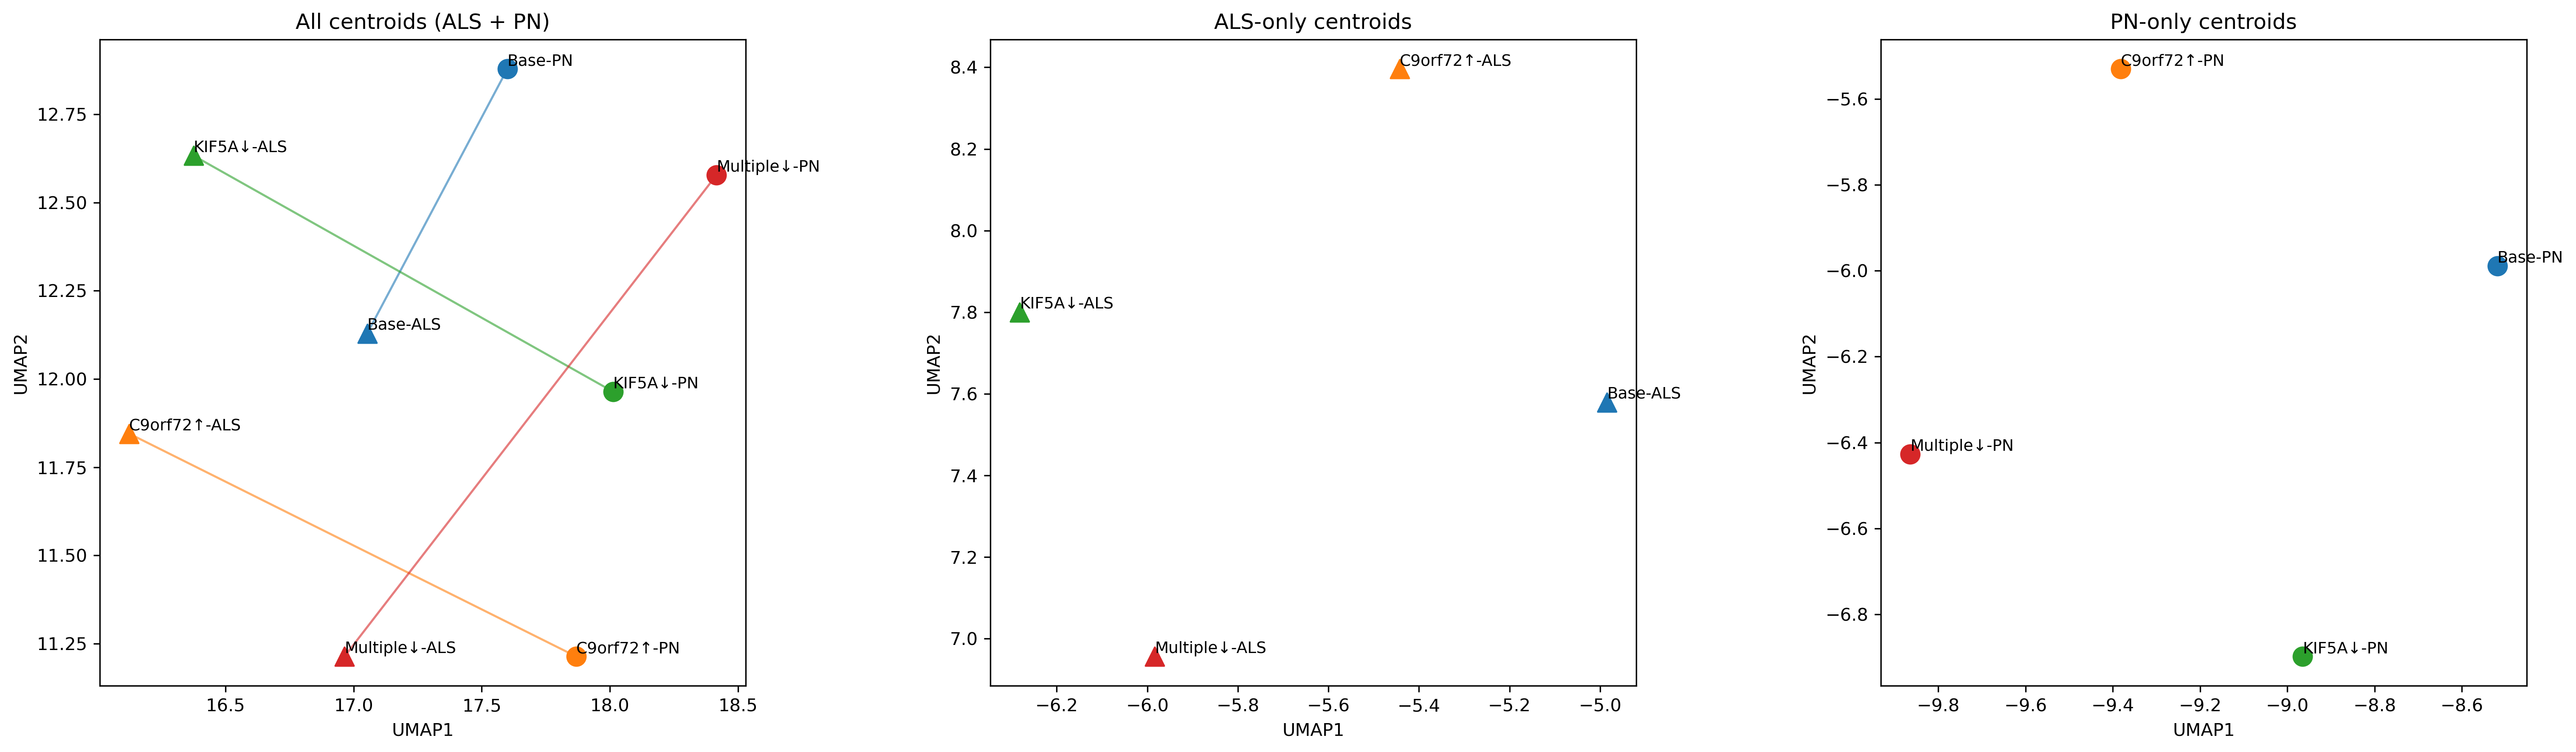

In [ ]:
names  = ["Base","C9orf72↑","KIF5A↓","Multiple↓"]
embeds = [E_base, E_c9_als_up, E_k5_als_down, E_multiple_down]
adatas = [base,   C9orf72_als_up, KIF5A_als_down, multiple_als_down]

centroids, states, cohorts = [], [], []
for n, E, A in zip(names, embeds, adatas):
    cond = _norm_labels(A.obs["Condition"])
    for c in ["ALS", "PN"]:
        idx = np.flatnonzero(cond.values == c)
        if idx.size > 0:
            if E.shape[0] < idx.max() + 1:
                raise ValueError(f"Embeddings for {n} have {E.shape[0]} rows but adata has index up to {idx.max()}.")
            centroids.append(_centroid(E[idx]))
            states.append(n)
            cohorts.append(c)

if len(centroids) == 0:
    raise ValueError("No ALS/PN matches found after normalization.")

X = np.vstack(centroids)

state_list    = list(dict.fromkeys(states))
state_colors  = {s: plt.cm.tab10(i % 10) for i, s in enumerate(state_list)}
cohort_marker = {"ALS": "^", "PN": "o"}

def _scatter_to_ax(ax, X2, labs_state, labs_cohort, title):
    for i, (s, c) in enumerate(zip(labs_state, labs_cohort)):
        ax.scatter(X2[i,0], X2[i,1], s=110, c=[state_colors[s]], marker=cohort_marker.get(c, "o"))
        ax.text(X2[i,0], X2[i,1], f"{s}-{c}", fontsize=9, ha="left", va="bottom")
    for s in state_list:
        idx = [i for i, ss in enumerate(labs_state) if ss == s]
        if len(idx) >= 2:
            ax.plot(X2[idx,0], X2[idx,1], linewidth=1.2, alpha=0.6, c=state_colors[s])
    ax.set_title(title)
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.set_box_aspect(1)

fig, axes = plt.subplots(1, 3, figsize=(21, 6), dpi=300)

if X.shape[0] >= 2:
    umap_all = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric="euclidean", random_state=0)
    Xu_all = umap_all.fit_transform(X)
    _scatter_to_ax(axes[0], Xu_all, states, cohorts, "All centroids (ALS + PN)")
else:
    axes[0].axis("off")

idx_als = [i for i, c in enumerate(cohorts) if c == "ALS"]
if len(idx_als) >= 2:
    X_als = X[idx_als]
    umap_als = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric="euclidean", random_state=0)
    Xu_als = umap_als.fit_transform(X_als)
    _scatter_to_ax(axes[1], Xu_als, [states[i] for i in idx_als], ["ALS"]*len(idx_als), "ALS-only centroids")
else:
    axes[1].axis("off")

idx_pn = [i for i, c in enumerate(cohorts) if c == "PN"]
if len(idx_pn) >= 2:
    X_pn = X[idx_pn]
    umap_pn = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric="euclidean", random_state=0)
    Xu_pn = umap_pn.fit_transform(X_pn)
    _scatter_to_ax(axes[2], Xu_pn, [states[i] for i in idx_pn], ["PN"]*len(idx_pn), "PN-only centroids")
else:
    axes[2].axis("off")

plt.tight_layout()
plt.show()

**Figure 2**: Clearly, we can see that it would be much harder to interpret the UMAP in this space, because even the centroids for the PN cells - which are completely unperturbed in all cases - do not overlap. Therefore, we can move on to quantifying just how far apart these centroids are in the latent space based on principal components.